# Avalanche Bulletins
Avalanche bulletins for Tyrol and South Tyrol are published daily (sometimes even twice a day) during the avalanche season, typically from mid-November until the beginning of May. Since 2018, these bulletins have been available in JSON format as well as an interactive bulletin on the webpage of the Avalanche Warning Service Tyrol. [[source](https://avalanche.report/more/archive)]

In [1]:
import json
import pprint
from datetime import datetime
from pathlib import Path

import calplot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from avalancheutils.bulletins import fetch_bulletins, get_bulletin_data_for_incidents, \
    check_matching_danger_problem_size
from avalancheutils.data_preprocessing import unique_value_counts
from avalancheutils.visualization import plot_pie_chart

## Fetching the Data
The available archived bulletin summaries were downloaded as JSON files and stored in the `data/cache/bulletins` folder. Only new and missing bulletins will be downloaded. If you need to re-fetch them, simply delete all bulletin files from the folder or change the output folder.

In [2]:
bulletins = fetch_bulletins('data/cache/bulletins/')

Successfully fetched avalanche bulletin for the date: 2018-12-04
Successfully fetched avalanche bulletin for the date: 2018-12-05
Successfully fetched avalanche bulletin for the date: 2018-12-06
Successfully fetched avalanche bulletin for the date: 2018-12-07
Successfully fetched avalanche bulletin for the date: 2018-12-08
Successfully fetched avalanche bulletin for the date: 2018-12-09
Successfully fetched avalanche bulletin for the date: 2018-12-10
Successfully fetched avalanche bulletin for the date: 2018-12-11
Successfully fetched avalanche bulletin for the date: 2018-12-12
Successfully fetched avalanche bulletin for the date: 2018-12-13
Successfully fetched avalanche bulletin for the date: 2018-12-15
Successfully fetched avalanche bulletin for the date: 2018-12-16
Successfully fetched avalanche bulletin for the date: 2018-12-17
Successfully fetched avalanche bulletin for the date: 2018-12-18
Successfully fetched avalanche bulletin for the date: 2018-12-19
Successfully fetched aval

In [3]:
bulletins.info()
bulletins.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 940 entries, 2018-12-04 to 2024-05-05
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   bulletins  940 non-null    object
dtypes: object(1)
memory usage: 14.7+ KB


,bulletins
2018-12-04,[{'avalancheActivity': {'comment': 'The old sn...
2018-12-05,[{'avalancheActivity': {'comment': 'The fresh ...
2018-12-06,[{'avalancheActivity': {'comment': 'The fresh ...
2018-12-07,[{'avalancheActivity': {'comment': 'The fresh ...
2018-12-08,[{'avalancheActivity': {'comment': 'Significan...


The avalanche bulletins are stored in a DataFrame with their date of validity as the index and the contents of the bulletins in a list of dictionaries in the `bulletins` column.

In [4]:
cal_series = pd.Series(bulletins.index).value_counts()

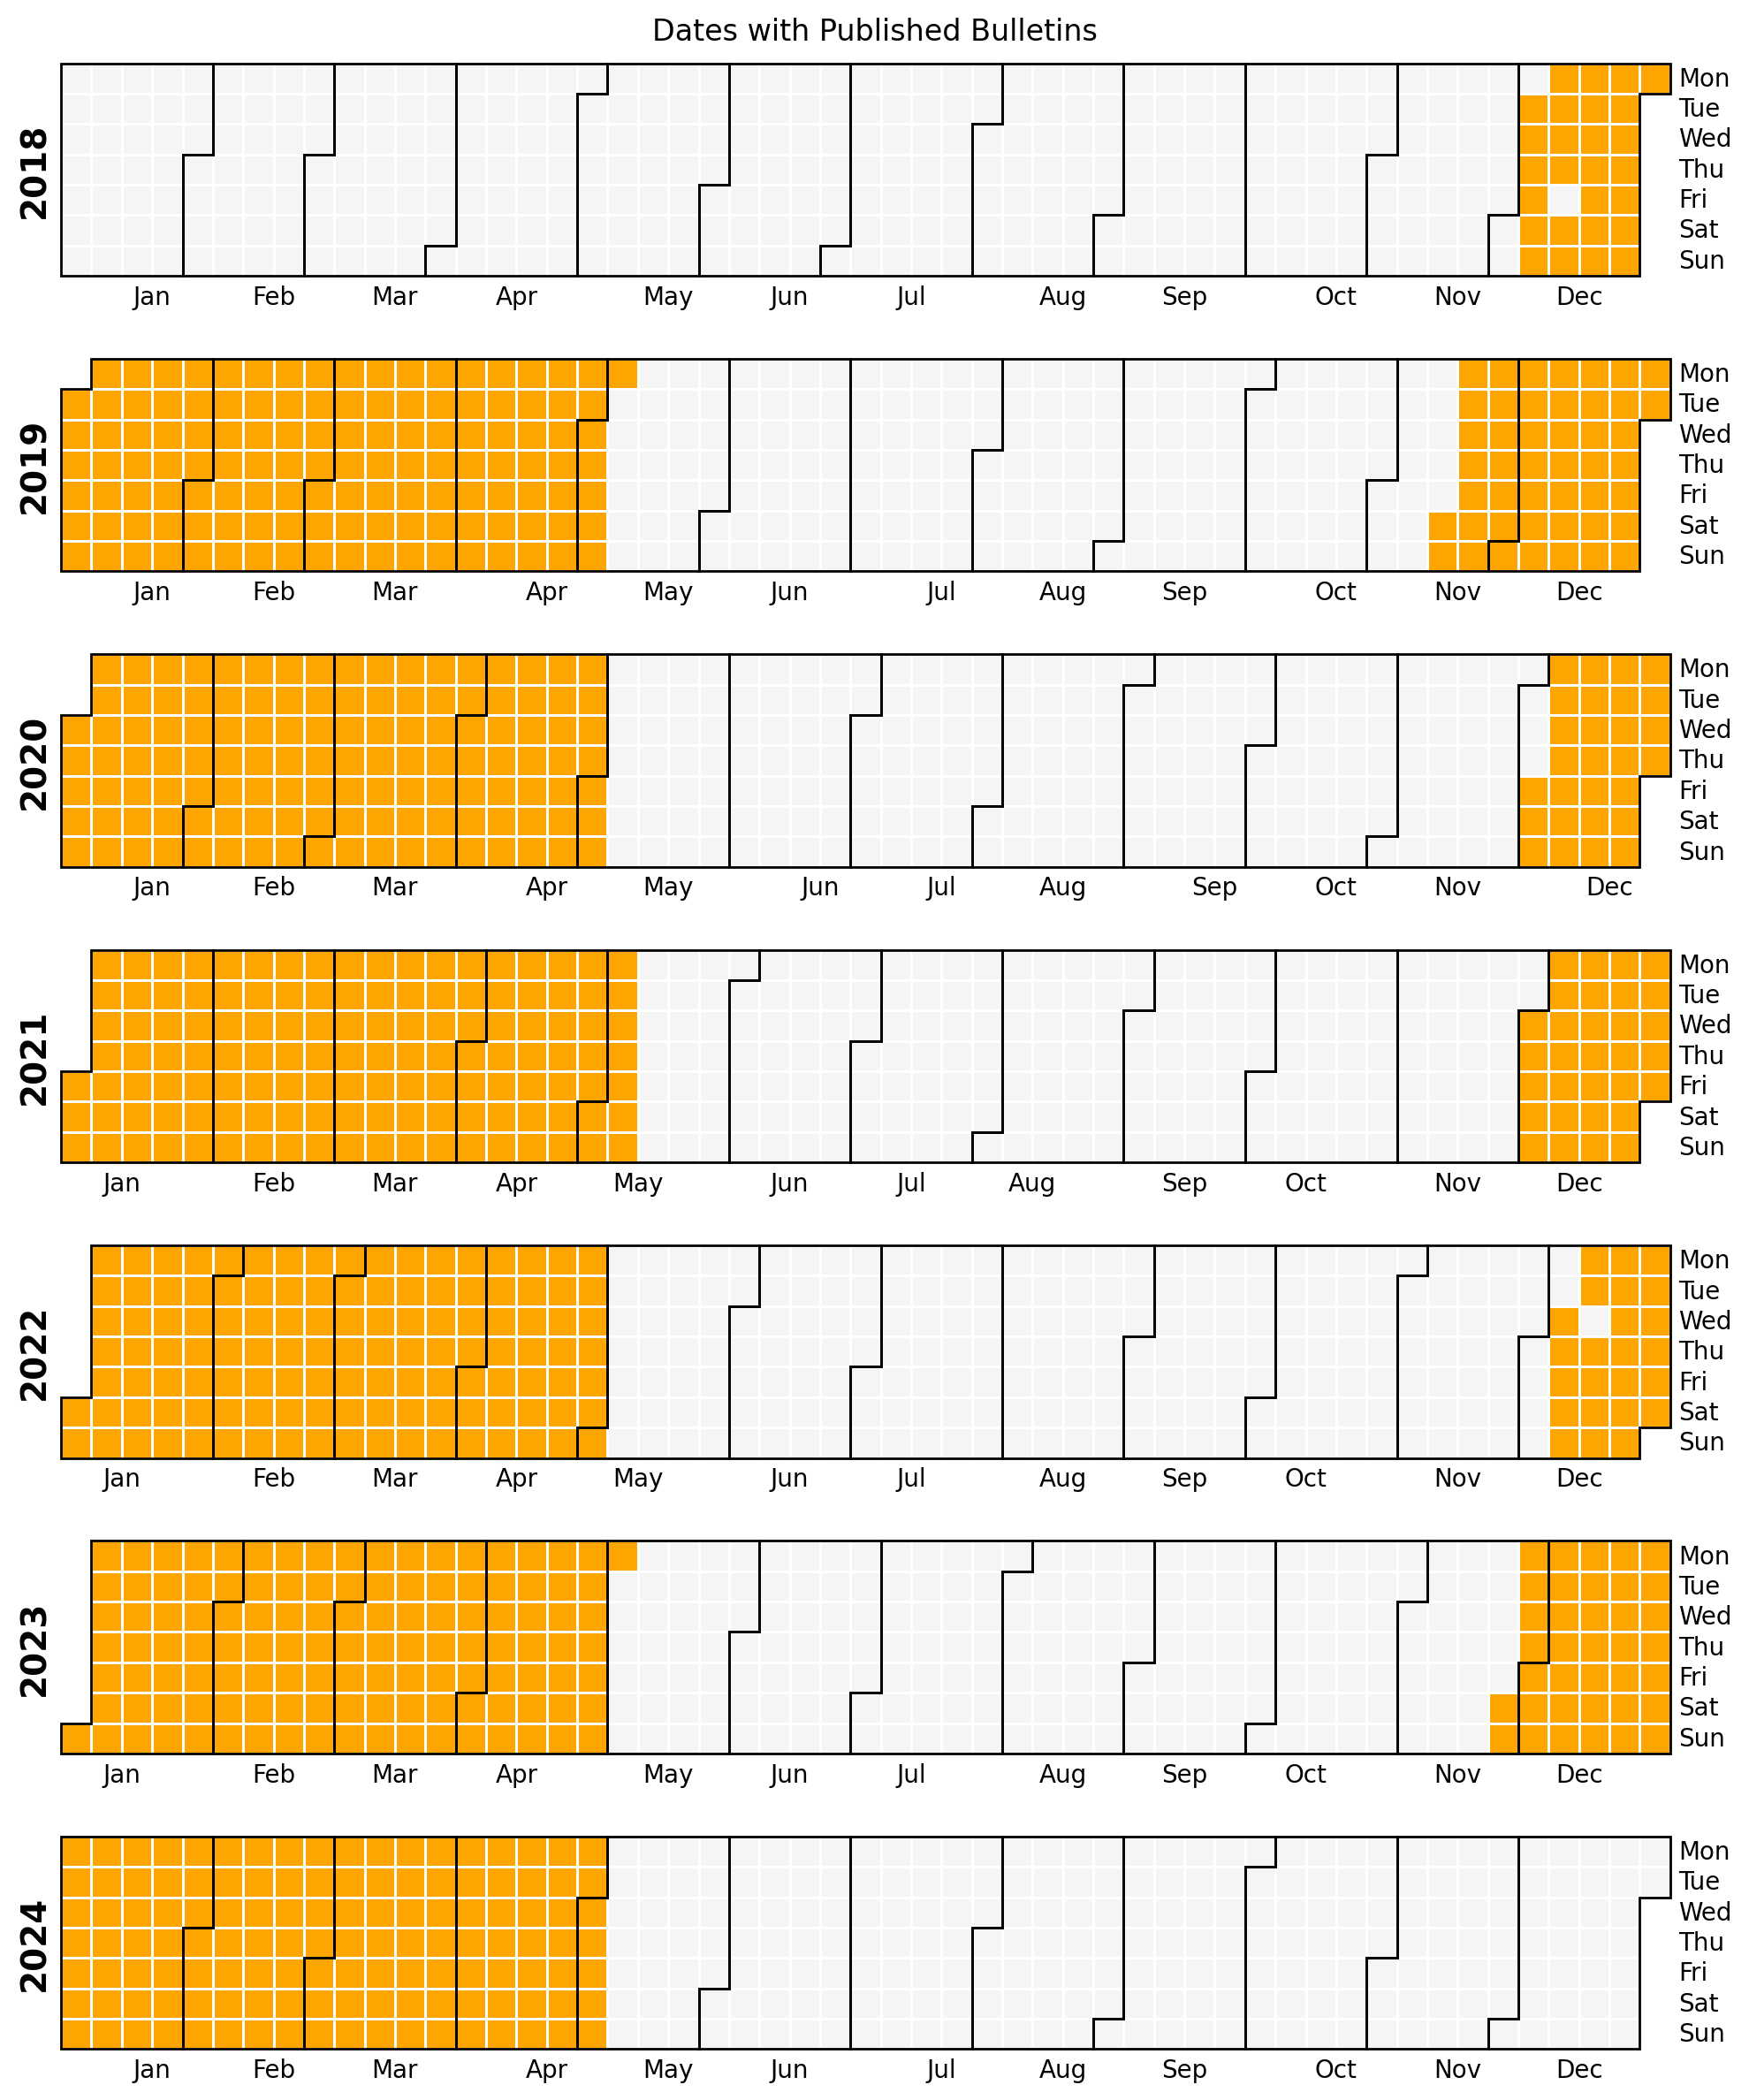

In [5]:
import matplotlib

cmap = matplotlib.colors.ListedColormap(['orange'])
calplot.calplot(cal_series,
                yearlabel_kws={'color': 'black', 'fontsize': 14, 'fontname': 'DejaVu Sans'}, cmap=cmap,
                linecolor='white', edgecolor='black', suptitle='Dates with Published Bulletins',
                fig_kws={'dpi': 200})
plt.show()

As seen in this calendar plot of all available bulletins, bulletins are typically published from the first half of December until the first week of May.

### Bulletin JSON File Structure

The bulletins are structured in the following format:

In [6]:
print('The most recent avalanche bulletin:\n')
pprint.pprint(bulletins.iloc[-1]['bulletins'])

The most recent avalanche bulletin:

[{'avalancheActivity': {'comment': 'Individual wet and gliding avalanches are '
                                   'possible. In very isolated cases '
                                   'avalanches can release the saturated '
                                   'snowpack and reach a dangerous size. As a '
                                   'consequence of warming during the day and '
                                   'solar radiation only isolated loose snow '
                                   'avalanches are to be expected, especially '
                                   'in steep rocky terrain in all aspects. '
                                   '<br/> Individual avalanche prone locations '
                                   'for dry avalanches are to be found in '
                                   'extremely steep terrain at high altitudes '
                                   'and in high Alpine regions. Apart from the '
                       

Every bulletin summary contains an array with the bulletins for different subregions in the Tyrol region (`bulletins`). The bulletins are published for the whole day, with the possibility to further divide the prevision into the morning and afternoon period (`validTimePeriod`).
 
Each bulletin contains the specified danger rating according to the EAWS danger rating scale (`dangerRatings`), along with an array of possible avalanche problems (`avalancheProblems`). For each avalanche problem, further information is provided, such as the affected aspects (`aspects`) and elevation range (`elevation`), as well as avalanche size (`avalancheSize`). Most importantly, every bulletin specifies the affected regions (`regions`) by including an array with both the EAWS region codes (`regionID`) and region names (`name`).

## Adding the EAWS Region Code

In [7]:
incidents = pd.read_csv('data/incidents_tirol_processed.csv', parse_dates=['date'])
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            1109 non-null   int64         
 1   date                          1109 non-null   datetime64[ns]
 2   valid_time                    1109 non-null   bool          
 3   location_longitude            1109 non-null   float64       
 4   location_latitude             1109 non-null   float64       
 5   danger_rating                 1054 non-null   float64       
 6   danger_problem                478 non-null    object        
 7   involved_sum                  750 non-null    float64       
 8   involved_dead                 974 non-null    float64       
 9   involved_injured              976 non-null    float64       
 10  involved_uninjured            772 non-null    float64       
 11  involved_swept                

For further effective comparison, it is needed to add the EAWS region code to every incident. In the dataset, the subregion data for each incident are stored in the `location_subregion` column. A list of all the valid region code is available in the EAWS GitLab repository. [[source](https://gitlab.com/eaws/eaws-regions/-/blob/master/public/micro-regions_names/de.json)] Individual subregions have changed and further subdivided over time [[source](https://gitlab.com/eaws/eaws-regions/-/blob/master/public/micro-regions_properties/AT-07_micro-regions.json)], so it is important to assign a code valid at the time of avalanche release to each avalanche.

In [8]:
with Path('assets/eaws_regions.json').open('r') as region_codes:
    region_codes_json = json.load(region_codes)
regions = pd.DataFrame(list(region_codes_json.items()))
regions.columns = ['region_code', 'region_name']
regions = regions[regions['region_code'].str.startswith('AT-07-')]  # we are only interested in Tyrol
regions

,region_code,region_name
93,AT-07-01,Allgäuer Alpen
94,AT-07-02,Östliche Lechtaler Alpen - Ammergauer Alpen
95,AT-07-02-01,Ammergauer Alpen
96,AT-07-02-02,Östliche Lechtaler Alpen
97,AT-07-03,Mieminger Gebirge
98,AT-07-04,Karwendel
99,AT-07-04-01,Westliches Karwendel
100,AT-07-04-02,Östliches Karwendel
101,AT-07-05,Brandenberger Alpen
102,AT-07-06,Wilder Kaiser - Waidringer Alpen


Let's also add its validity period to each region:

In [9]:
regions_validity = pd.read_json('assets/eaws_regions_validity.json')
regions_validity.columns = ['region_code', 'start_date', 'end_date']
regions_validity['start_date'] = pd.to_datetime(regions_validity['start_date'])
regions_validity['start_date'] = regions_validity['start_date'].fillna(
    pd.Timestamp(0))  # fill the missing values with the start of the Unix epoch
regions_validity['end_date'] = pd.to_datetime(regions_validity['end_date'])
regions_validity['end_date'] = regions_validity['end_date'].fillna(
    pd.Timestamp(datetime.now().date()))  # fill the missing values with the today's date

In [10]:
regions = regions.merge(regions_validity, how='left', on='region_code')
regions

,region_code,region_name,start_date,end_date
0,AT-07-01,Allgäuer Alpen,1970-01-01,2024-05-15
1,AT-07-02,Östliche Lechtaler Alpen - Ammergauer Alpen,1970-01-01,2022-10-01
2,AT-07-02-01,Ammergauer Alpen,2022-10-01,2024-05-15
3,AT-07-02-02,Östliche Lechtaler Alpen,2022-10-01,2024-05-15
4,AT-07-03,Mieminger Gebirge,1970-01-01,2024-05-15
5,AT-07-04,Karwendel,1970-01-01,2022-10-01
6,AT-07-04-01,Westliches Karwendel,2022-10-01,2024-05-15
7,AT-07-04-02,Östliches Karwendel,2022-10-01,2024-05-15
8,AT-07-05,Brandenberger Alpen,1970-01-01,2024-05-15
9,AT-07-06,Wilder Kaiser - Waidringer Alpen,1970-01-01,2024-05-15


In the data, certain subregion names are presented in abbreviated form, requiring them to be renamed into a consistent format.

In [11]:
invalid_names = (incidents[~incidents['location_subregion'].isin(regions["region_name"])])[
    'location_subregion'].unique()
print("List of invalid subregion names in the dataset:")
print(invalid_names)

List of invalid subregion names in the dataset:
['Westl. Kitzbüheler Alpen' 'Westl. Verwallgruppe' 'Westl. Tuxer Alpen'
 'Nördl. Ötztaler- & Stubaier Alpen' 'Östl. Verwallgruppe'
 'Östl. Deferegger Alpen' 'Östl. Lechtaler A. - Ammergauer A.'
 'Nördl. Zillertaler Alpen' 'Östl. Kitzbüheler Alpen' 'Östl. Tuxer Alpen'
 'Westl. Lechtaler Alpen' 'Östl. Lechtaler Alpen']


In [12]:
corrections = {
    'Westl. Kitzbüheler Alpen': 'Westliche Kitzbüheler Alpen',
    'Westl. Verwallgruppe': 'Westliche Verwallgruppe',
    'Westl. Tuxer Alpen': 'Westliche Tuxer Alpen',
    'Nördl. Ötztaler- & Stubaier Alpen': 'Nördliche Ötztaler- und Stubaier Alpen',
    'Östl. Verwallgruppe': 'Östliche Verwallgruppe',
    'Östl. Deferegger Alpen': 'Östliche Deferegger Alpen',
    'Östl. Lechtaler A. - Ammergauer A.': 'Östliche Lechtaler Alpen - Ammergauer Alpen',
    'Nördl. Zillertaler Alpen': 'Nördliche Zillertaler Alpen',
    'Östl. Kitzbüheler Alpen': 'Östliche Kitzbüheler Alpen',
    'Östl. Tuxer Alpen': 'Östliche Tuxer Alpen',
    'Westl. Lechtaler Alpen': 'Westliche Lechtaler Alpen',
    'Östl. Lechtaler Alpen': 'Östliche Lechtaler Alpen'
}
incidents['location_subregion'] = incidents['location_subregion'].replace(corrections)

In [13]:
invalid_names = (incidents[~incidents['location_subregion'].isin(regions["region_name"])])[
    'location_subregion'].unique()
print("List of invalid subregion names in the dataset:")
print(invalid_names)

List of invalid subregion names in the dataset:
[]


In [14]:
incidents = incidents.merge(regions, how='left', left_on='location_subregion', right_on='region_name')

In [15]:
incidents[incidents['id'].duplicated(keep=False)]

,id,date,valid_time,location_longitude,location_latitude,danger_rating,danger_problem,involved_sum,involved_dead,involved_injured,...,weather_rain_sum,weather_snow_sum,weather_wind_speed_mean,weather_wind_dir_mean,weather_radiation_sum,week_day,region_code,region_name,start_date,end_date
0,9354,2018-02-17 11:34:00,True,11.98533,47.27433,3.0,NaN,0.0,0.0,0.0,...,0.4,15.330001,1.765809,236.022186,30.590000,5,AT-07-17,Westliche Kitzbüheler Alpen,1970-01-01,2022-10-01
1,9354,2018-02-17 11:34:00,True,11.98533,47.27433,3.0,NaN,0.0,0.0,0.0,...,0.4,15.330001,1.765809,236.022186,30.590000,5,AT-07-17-01,Westliche Kitzbüheler Alpen,2022-10-01,2024-05-15
8,9348,2018-02-16 11:20:00,True,12.14483,47.30417,3.0,NaN,2.0,0.0,0.0,...,0.4,13.510000,1.801052,232.647991,29.210001,4,AT-07-17,Westliche Kitzbüheler Alpen,1970-01-01,2022-10-01
9,9348,2018-02-16 11:20:00,True,12.14483,47.30417,3.0,NaN,2.0,0.0,0.0,...,0.4,13.510000,1.801052,232.647991,29.210001,4,AT-07-17-01,Westliche Kitzbüheler Alpen,2022-10-01,2024-05-15
11,9382,2018-02-24 00:00:00,False,12.11602,47.31589,2.0,NaN,1.0,0.0,0.0,...,0.0,4.130000,2.180376,51.051593,36.270000,5,AT-07-17,Westliche Kitzbüheler Alpen,1970-01-01,2022-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049,10626,2023-02-04 16:15:00,True,11.98415,47.39101,4.0,wind_slab,0.0,0.0,0.0,...,0.1,30.169994,3.524486,266.649820,14.400000,5,AT-07-17-01,Westliche Kitzbüheler Alpen,2022-10-01,2024-05-15
1058,10645,2023-02-08 11:48:00,True,12.00757,47.36509,3.0,persistent_weak_layers,1.0,0.0,0.0,...,0.0,1.330000,1.875242,233.844367,36.860000,2,AT-07-17,Westliche Kitzbüheler Alpen,1970-01-01,2022-10-01
1059,10645,2023-02-08 11:48:00,True,12.00757,47.36509,3.0,persistent_weak_layers,1.0,0.0,0.0,...,0.0,1.330000,1.875242,233.844367,36.860000,2,AT-07-17-01,Westliche Kitzbüheler Alpen,2022-10-01,2024-05-15
1137,10818,2024-01-28 00:00:00,False,12.04934,47.27455,2.0,wind_slab,0.0,0.0,0.0,...,2.0,22.260000,2.159083,260.323672,25.550000,6,AT-07-17,Westliche Kitzbüheler Alpen,1970-01-01,2022-10-01


After merging, some records are duplicated due to multiple possible region codes for the subregion name provided in the incident dataset. Let's filter them based on the validity of the individual subregion codes.

In [16]:
incidents = incidents[(incidents['date'] > incidents['start_date']) & (incidents['date'] <= incidents['end_date'])]
print(f'Are there any duplicates in the dataset? {incidents['id'].duplicated().any()}.')

Are there any duplicates in the dataset? False.


In [17]:
incidents = incidents.drop(columns=['start_date', 'end_date', 'region_name'])
incidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1109 entries, 0 to 1177
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            1109 non-null   int64         
 1   date                          1109 non-null   datetime64[ns]
 2   valid_time                    1109 non-null   bool          
 3   location_longitude            1109 non-null   float64       
 4   location_latitude             1109 non-null   float64       
 5   danger_rating                 1054 non-null   float64       
 6   danger_problem                478 non-null    object        
 7   involved_sum                  750 non-null    float64       
 8   involved_dead                 974 non-null    float64       
 9   involved_injured              976 non-null    float64       
 10  involved_uninjured            772 non-null    float64       
 11  involved_swept                970 n

## Comparison of Avalanche Bulletins and Reported Incidents

**Note:** Many avalanche bulletins frequently use the term `treeline` as the elevation boundary for danger ratings and avalanche problems. The term is defined as follows: The alpine treeline is the fundamental limit of the arboreal growth form (arguably the most dominating life form in Earth’s vegetation) and marks the transition from tree-dominated vegetation to treeless alpine scrub or grassland). [[source](https://www.sciencedirect.com/referencework/9780128004265/encyclopedia-of-evolutionary-biology)] The altitude of the treeline is primarily influenced by latitude, but it is also affected by factors such as the aspect of the slope and overall climate. In recent years, the elevation of the treeline has been increasing due to climate change. 

Determining the treeline for each location in the Alps poses a significant challenge and depends greatly on the chosen methodology, as highlighted in the article 'GIS-analysis of tree-line elevation in the Swiss Alps suggests no exposure effect' [[source](https://doi.org/10.2307/3236869)]. Furthermore, there is no publicly available model for the treelines in Tyrol. Following email correspondence with the Tyrol Avalanche Warning Service, and considering the absence of a dedicated model, I opted to assign it a value of approximately 2300 m.a.s.l to the treeline in Tyrol. This decision was based on the information published on the Tirol Atlas website [[source](https://tirolatlas.uibk.ac.at/topics/corine/query.py/text?id=8120006)].

In [18]:
treeline_elevation = 2300

There is a large number of incidents in the dataset that happened before the publication of the first avalanche bulletin. Let's first filter out only incidents that happened after the publication.

In [19]:
earliest_date = bulletins.index.min()
incidents_for_analysis = incidents[incidents['date'] >= earliest_date]

### Creating a Comparison Table
First, a comparison table will be created. Its structure is as follows:
| **Column Name** | **Description**                                                              | **Data Type** |
|-----------------|------------------------------------------------------------------------------|---------------|
| id              | Incident identifier                                                          | int           |
| bulletin_exists | Prediction was created for the given date                                    | bool          |
| region_code     | Prediction exists for the given region                                       | bool          |
| danger_rating   | Forecasted avalanche danger level                                            | int           |
| danger_problem  | Field containing all relevant avalanche problems and their altitude validity | list          |

In [20]:
incident_bulletin_data = get_bulletin_data_for_incidents(incidents_for_analysis, bulletins)
incident_bulletin_data

,id,bulletin_exists,region_code,danger_rating,danger_problem
0,9474,True,True,2.0,[{'danger_problem': 'wind_slab'}]
1,9476,True,True,NaN,"[{'danger_problem': 'wind_slab', 'elevation': ..."
2,9478,True,True,NaN,"[{'danger_problem': 'wind_slab', 'elevation': ..."
3,9475,True,True,3.0,"[{'danger_problem': 'wind_slab'}, {'danger_pro..."
4,9495,True,True,3.0,"[{'danger_problem': 'wind_slab'}, {'danger_pro..."
...,...,...,...,...,...
500,10872,True,True,NaN,"[{'danger_problem': 'wind_slab', 'size': 2, 'e..."
501,10871,True,True,2.0,NaN
502,10817,True,True,2.0,"[{'danger_problem': 'wind_slab', 'size': 2}]"
503,10873,True,True,2.0,"[{'danger_problem': 'wind_slab', 'size': 2}]"


In [21]:
incident_bulletin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               505 non-null    int64  
 1   bulletin_exists  478 non-null    object 
 2   region_code      475 non-null    object 
 3   danger_rating    316 non-null    float64
 4   danger_problem   418 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 19.9+ KB


The comparison table will be merged with the dataset on matching incident id.

In [22]:
incidents = incidents.merge(incident_bulletin_data, how='left', on='id', suffixes=('', '_bulletin'))

### Comparing the Danger Ratings
As the danger rating data has been acquired for every incident included in the bulletins, we can now compare the data to identify any differences.

In [23]:
danger_rating_comparison = incidents[incidents['danger_rating_bulletin'].notnull()]
display(unique_value_counts(danger_rating_comparison['danger_rating'], title='Danger Rating from LAWIS'))
display(unique_value_counts(danger_rating_comparison['danger_rating_bulletin'], title="Danger Rating from Bulletin"))

Unique values for the property "Danger Rating from LAWIS" (5 unique values and 310 / 316 non-null values):



danger_rating
3.0    128
2.0    112
4.0     26
1.0     22
0.0     22
Name: count, dtype: int64

Unique values for the property "Danger Rating from Bulletin" (5 unique values and 316 / 316 non-null values):



danger_rating_bulletin
3.0    126
2.0    106
0.0     30
1.0     28
4.0     26
Name: count, dtype: int64

The danger rating can be assessed onsite by the avalanche experts, so the danger ratings can vary from the predicted value in the bulletin. However the new danger ratings shouldn't normally be lower. Let's look closely at all the mismatched values.

In [24]:
mismatched_incidents = incidents[(incidents['danger_rating'] != incidents['danger_rating_bulletin']) &
                                 (incidents['danger_rating_bulletin'].notnull()) |
                                 ((incidents['danger_rating'].isnull()) & (
                                     incidents['danger_rating_bulletin'].notnull()))][
    ['id', 'date', 'danger_rating', 'danger_rating_bulletin']]
print(f"Number of mismatched danger ratings: {len(mismatched_incidents)}")
mismatched_incidents.columns = ['id', 'Date', 'LAWIS Danger Rating', 'Bulletin Danger Rating']
mismatched_incidents

Number of mismatched danger ratings: 24


,id,Date,LAWIS Danger Rating,Bulletin Danger Rating
551,9496,2018-12-27 12:06:00,2.0,1.0
560,9490,2018-12-27 11:30:00,2.0,3.0
584,9681,2019-02-01 08:11:00,2.0,3.0
585,9684,2019-02-02 16:20:00,3.0,4.0
609,9752,2019-04-14 10:59:00,3.0,2.0
610,9750,2019-04-06 11:22:00,2.0,3.0
697,9833,2020-02-08 12:12:00,2.0,1.0
709,9885,2020-05-07 10:45:00,NaN,0.0
712,9880,2020-05-06 10:01:00,NaN,0.0
713,9881,2020-05-07 11:09:00,NaN,0.0


In [25]:
mismatched_incidents[mismatched_incidents['LAWIS Danger Rating'] > mismatched_incidents['Bulletin Danger Rating']]

,id,Date,LAWIS Danger Rating,Bulletin Danger Rating
551,9496,2018-12-27 12:06:00,2.0,1.0
609,9752,2019-04-14 10:59:00,3.0,2.0
697,9833,2020-02-08 12:12:00,2.0,1.0
838,10238,2021-03-20 11:50:00,3.0,1.0
845,10273,2021-03-26 12:41:00,2.0,1.0
867,10337,2021-01-08 11:00:00,4.0,2.0
893,10420,2022-02-13 12:20:00,3.0,0.0
913,10428,2022-02-14 00:00:00,3.0,1.0
916,10444,2022-02-27 10:23:00,2.0,1.0
992,10654,2023-02-19 14:48:00,2.0,1.0


Not only are there mismatched values, but we also observe a couple of incidents without a recorded danger rating. Most of them are out of the bulletin season probably therefore the danger rating published in the bulletins for those events is 0 (not assigned).

### Comparing the Avalanche Problems
#### Ignoring the Treeline Boundaries

In [26]:
matching_danger_problem_no_treeline = incidents.apply(check_matching_danger_problem_size, purge_treeline=True, axis=1,
                                                      result_type='expand')
matching_danger_problem_no_treeline

,danger_problem,avalanche_size
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
1104,NaN,NaN
1105,NaN,NaN
1106,False,NaN
1107,wind_slab,2.0


In [27]:
unique_value_counts(matching_danger_problem_no_treeline['danger_problem'],
                    "Matching Danger Problem without Treeline Records")

Unique values for the property "Matching Danger Problem without Treeline Records" (5 unique values and 246 / 1109 non-null values):



danger_problem
False                     110
persistent_weak_layers     79
wind_slab                  41
gliding_snow                8
wet_snow                    8
Name: count, dtype: int64

In [28]:
matching_danger_problem_no_treeline['matching'] = np.where(
    matching_danger_problem_no_treeline['danger_problem'].isin([False, np.nan]),
    matching_danger_problem_no_treeline['danger_problem'], True)
unique_value_counts(matching_danger_problem_no_treeline['matching'],
                    title='Do the Danger Problems Match? (no treeline)')

Unique values for the property "Do the Danger Problems Match? (no treeline)" (2 unique values and 246 / 1109 non-null values):



matching
True     136
False    110
Name: count, dtype: int64

In [29]:
pie_data = matching_danger_problem_no_treeline['matching'].value_counts().sort_index()

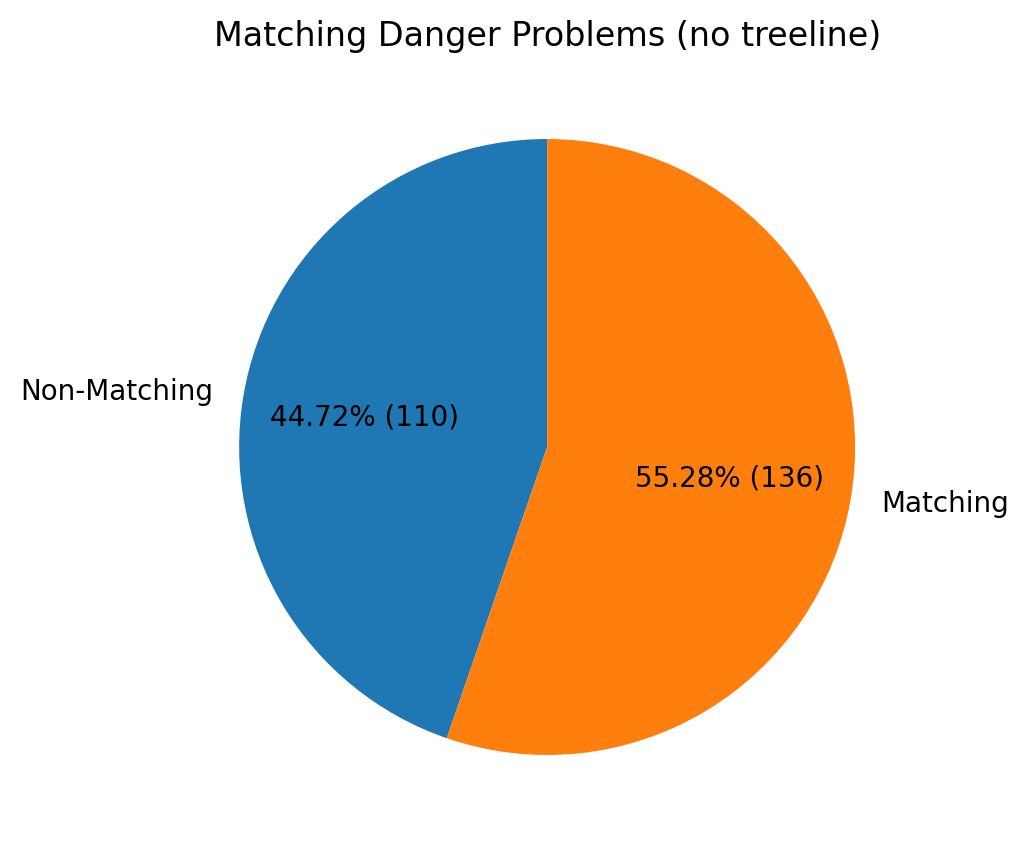

In [30]:
plot_pie_chart(pie_data, title='Matching Danger Problems (no treeline)', labels=['Non-Matching', 'Matching'])
plt.show()

#### Including the Treeline Boundaries

In [31]:
matching_danger_problem_with_treeline = incidents.apply(check_matching_danger_problem_size,
                                                        treeline_elevation=treeline_elevation, purge_treeline=False,
                                                        axis=1, result_type='expand')
matching_danger_problem_with_treeline

,danger_problem,avalanche_size
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
1104,False,NaN
1105,NaN,NaN
1106,False,NaN
1107,wind_slab,2.0


In [32]:
unique_value_counts(matching_danger_problem_with_treeline['danger_problem'],
                    "Matching Danger Problem with Treeline Records")

Unique values for the property "Matching Danger Problem with Treeline Records" (6 unique values and 400 / 1109 non-null values):



danger_problem
False                     137
persistent_weak_layers    121
wind_slab                 105
new_snow                   20
gliding_snow                9
wet_snow                    8
Name: count, dtype: int64

In [33]:
matching_danger_problem_with_treeline['matching'] = np.where(
    matching_danger_problem_with_treeline['danger_problem'].isin([False, np.nan]),
    matching_danger_problem_with_treeline['danger_problem'], True)

In [34]:
pie_data = matching_danger_problem_with_treeline['matching'].value_counts().sort_index()

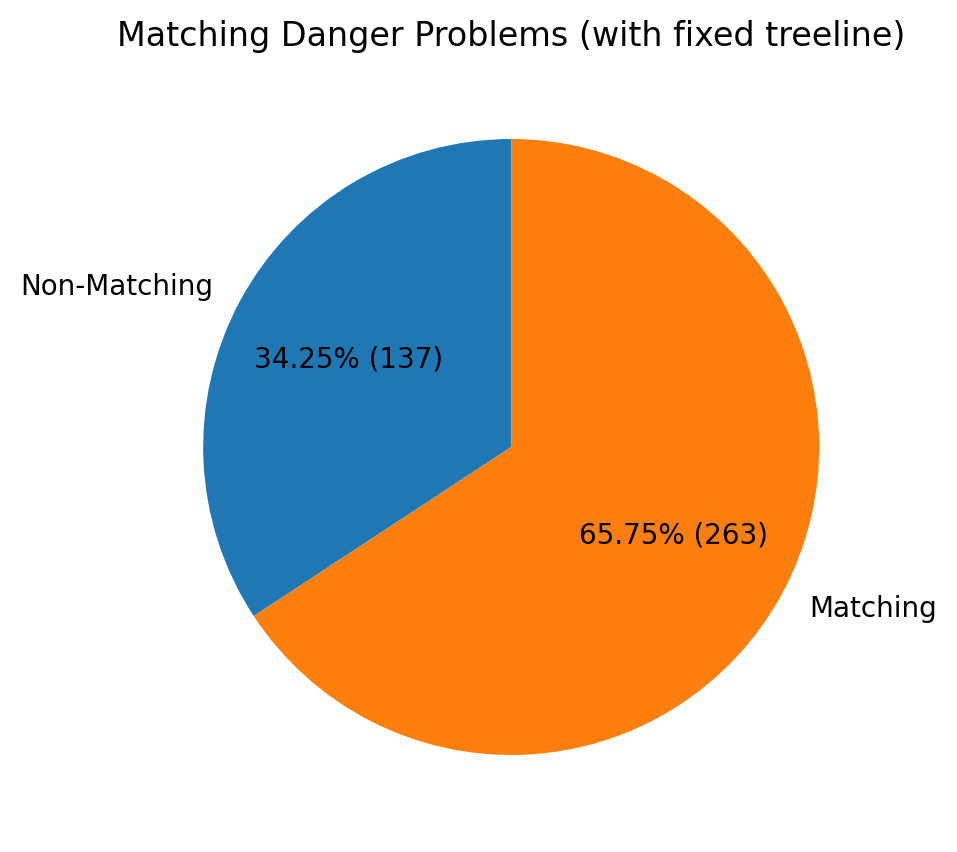

In [35]:
plot_pie_chart(pie_data, title='Matching Danger Problems (with fixed treeline)', labels=['Non-Matching', 'Matching'])
plt.show()

In [36]:
unique_value_counts(matching_danger_problem_with_treeline['matching'],
                    title='Do the Danger Problems Match? (with treeline)')

Unique values for the property "Do the Danger Problems Match? (with treeline)" (2 unique values and 400 / 1109 non-null values):



matching
True     263
False    137
Name: count, dtype: int64

### Comparing the Avalanche Sizes
Some avalanche bulletins include a maximal estimated avalanche size for certain danger problems. Now that we have determined whether the forecasted danger problem mentioned in the bulletin matches the real recorded danger problem from the avalanche incident site, we can proceed to compare the forecasted size of the avalanche with the recorded size. 

#### Ignoring the Treeline Boundaries
We will use the indices of the matching danger problems from the previous step as a mask to select the incidents whose size we can compare. First, we will filter the matching and non-matching avalanche sizes with a boolean mask.

In [37]:
mask = pd.notna(matching_danger_problem_no_treeline['danger_problem']) & (
            matching_danger_problem_no_treeline['danger_problem'] != False)

In [38]:
selected_rows = incidents[mask]
selected_bulletins = matching_danger_problem_no_treeline[mask]

In [39]:
matching_sizes_no_treeline = pd.Series(
    [
        np.nan if pd.isna(recorded_size) or pd.isna(predicted_size) else recorded_size == predicted_size
        for recorded_size, predicted_size in zip(selected_rows['avalanche_size'], selected_bulletins['avalanche_size'])
    ]
)

In [40]:
pie_data = matching_sizes_no_treeline.value_counts().sort_index()

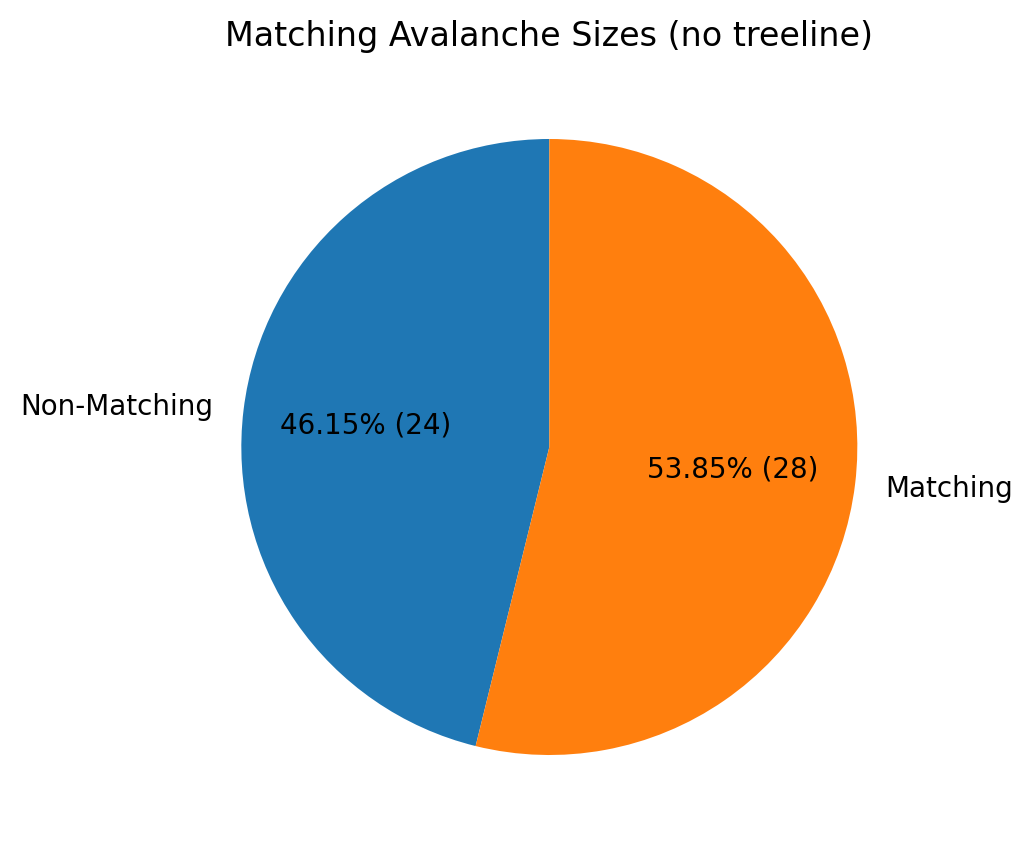

In [41]:
plot_pie_chart(pie_data, title='Matching Avalanche Sizes (no treeline)', labels=['Non-Matching', 'Matching'])
plt.show()

We can observe that most of the comparable events have matching sizes. Since the forecasted size is the maximal value, we can check for any mismatches with incidents' avalanche size higher than the forecasted size.

In [42]:
size_comparison_no_treeline = pd.DataFrame({'avalanche_size_incident': selected_rows['avalanche_size'],
                                            'avalanche_size_bulletin': selected_bulletins['avalanche_size']})
size_comparison_no_treeline[
    size_comparison_no_treeline['avalanche_size_bulletin'] < size_comparison_no_treeline['avalanche_size_incident']]

,avalanche_size_incident,avalanche_size_bulletin
941,3.0,2.0
949,4.0,3.0
993,3.0,2.0
1022,3.0,2.0
1099,3.0,2.0
1108,3.0,2.0


There are only 7 mismatches, and all of them differ by just one size grade. Therefore, it can be assumed that the forecasts are quite precise, considering they are for the whole region.

#### Including the Treeline Boundaries

In [43]:
mask = pd.notna(matching_danger_problem_with_treeline['danger_problem']) & (
            matching_danger_problem_with_treeline['danger_problem'] != False)

In [44]:
selected_rows = incidents[mask]
selected_bulletins = matching_danger_problem_with_treeline[mask]

In [45]:
matching_sizes_with_treeline = pd.Series(
    [
        np.nan if pd.isna(recorded_size) or pd.isna(predicted_size) else recorded_size == predicted_size
        for recorded_size, predicted_size in zip(selected_rows['avalanche_size'], selected_bulletins['avalanche_size'])
    ]
)

In [46]:
pie_data = matching_sizes_with_treeline.value_counts().sort_index()

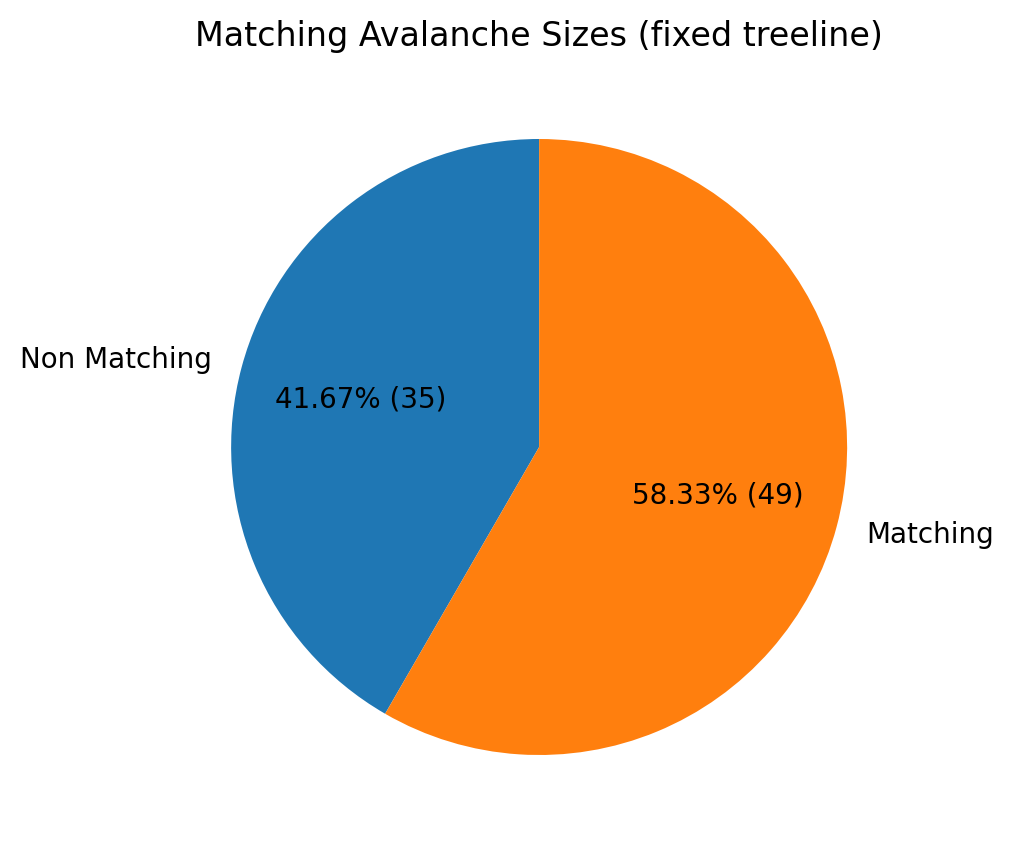

In [47]:
plot_pie_chart(pie_data, title='Matching Avalanche Sizes (fixed treeline)', labels=['Non Matching', 'Matching'])
plt.show()

The percentage of matches rose to 58% when taking into consideration also the `treeline` altitudes. 

Again, let's see the mismatches with higher recorded avalanche size than the predicted size.

In [48]:
size_comparison_with_treeline = pd.DataFrame({'avalanche_size_incident': selected_rows['avalanche_size'],
                                              'avalanche_size_bulletin': selected_bulletins['avalanche_size']})
size_comparison_with_treeline[
    size_comparison_with_treeline['avalanche_size_bulletin'] < size_comparison_with_treeline['avalanche_size_incident']]

,avalanche_size_incident,avalanche_size_bulletin
941,3.0,2.0
949,4.0,3.0
971,3.0,2.0
993,3.0,2.0
1022,3.0,2.0
1031,4.0,2.0
1064,4.0,3.0
1090,4.0,3.0
1099,3.0,2.0
1108,3.0,2.0


Now there are only 10 events, and considering that the number of comparable instances almost doubled, this is a very good result.